In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.chdir('/data/zhangjian/graduate_project/dataset_for_Tm/high-data/result_high_data')

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro

def process_tm_data(tm_data, length_threshold=3, alpha=0.05, diff_threshold=3, R_threshold=3):
    # 将输入的 Tm 数据字符串转换为浮点数列表
    try:
        tm_values = [float(tm) for tm in tm_data.split('/')]

        # 计算四分位数和箱体高度
        q1 = np.percentile(tm_values, 25)
        q3 = np.percentile(tm_values, 75)
        iqr = q3 - q1
        if len(tm_values) == 1:
            mean_tm = np.mean(tm_values)
        elif len(tm_values) == 2 and abs(tm_values[0] - tm_values[1]) <= diff_threshold:
            # 两个数据，差值小于等于3，计算平均值
            mean_tm = np.mean(tm_values)
        elif 3 <= len(tm_values) <= 4:
            # 三个或四个数据，使用肖维勒准则检验
            mean_value = np.mean(tm_values)
            std_dev = np.std(tm_values)
            # 计算Z得分
            z_scores = np.abs((tm_values - mean_value) / std_dev)
            threshold_z_score = 2.5
            data_filtered = [val for val, z_score in zip(tm_values, z_scores) if z_score <= threshold_z_score]
            std = np.max(data_filtered) - np.min(data_filtered)
            if std <= diff_threshold:
                mean_tm = np.mean(data_filtered)
            else:
                mean_tm = np.nan 
        elif len(tm_values) >= 5:
            # 五个及以上数据，使用原有算法（箱线图 + 肖维勒准则检验）
            if iqr < length_threshold:
            # 获取箱体内的数据
                #data_inside_box = [tm for tm in tm_values if q1 - 1.5 * iqr <= tm <= q3 + 1.5 * iqr]
                data_inside_box = [tm for tm in tm_values if q1<= tm <= q3]
            # 使用肖维勒准则检测箱体内数据是否存在异常值
                mean_data_inside_box = np.mean(data_inside_box)
                std_data_inside_box = np.std(data_inside_box)
                z_scores = np.abs((data_inside_box - mean_data_inside_box) / std_data_inside_box)

            # 设置阈值，如果存在任何一个数据点的Z得分超过阈值，则移除整组数据
                threshold_z_score = 2.5
                if np.any(z_scores > threshold_z_score):
                    mean_tm = np.nan
                else:
                    mean_tm = mean_data_inside_box 
            else:
                mean_tm = np.nan
        else:
            # 其他情况，无法满足条件，返回 NaN
            mean_tm = np.nan

        return mean_tm
    except:
        return np.nan


In [10]:
import pandas as pd
import requests
from io import BytesIO
import gzip
def uniprot_get_reviewed(input_data,species_ID=3702):
    
    temp_input = str(input_data).replace(' ','+')
    #url = f'https://rest.uniprot.org/uniprotkb/stream?compressed=true&download=true&fields=accession%2Cid%2Cprotein_name%2Corganism_name%2Clength&format=tsv&query=%28%28organism_id%3A{species_ID}%29%29+AND+%28reviewed%3Atrue%29%29'
    url = f'https://rest.uniprot.org/uniprotkb/stream?compressed=true&download=true&fields=accession%2Cid&format=tsv&query=%28%28taxonomy_id%3A{species_ID}%29+AND+%28protein_name%3A%22{temp_input}%22%29%29+AND+%28reviewed%3Atrue%29'
    response = requests.get(url)

    if response.status_code == 200:
        # 从响应中解压缩数据
        with gzip.GzipFile(fileobj=BytesIO(response.content), mode='rb') as f:
        # 读取解压缩后的数据并创建DataFrame
            temp = pd.read_csv(f, sep='\t')
            if temp.shape[0] == 0:
                print(f'no result for {input_data}')
                return np.nan
            elif temp.shape[0] == 1:
                uniprot = temp.loc[0,'Entry']
                return uniprot
            elif temp.shape[0] > 1:
                print(f'duplicate results for {input_data}')
                return np.nan
    else:
        print(f"no found for {input_data}")
        return np.nan
def uniprot_get_unreviewed(input_data,species_ID=3702):
    
    temp_input = str(input_data).replace(' ','+')
    #url = f'https://rest.uniprot.org/uniprotkb/stream?compressed=true&download=true&fields=accession%2Cid%2Cprotein_name%2Corganism_name%2Clength&format=tsv&query=%28%28organism_id%3A{species_ID}%29%29+AND+%28reviewed%3Atrue%29%29'
    url = f'https://rest.uniprot.org/uniprotkb/stream?compressed=true&download=true&fields=accession%2Cid&format=tsv&query=%28%28taxonomy_id%3A{species_ID}%29+AND+%28protein_name%3A%22{temp_input}%22%29%29'
    response = requests.get(url)

    if response.status_code == 200:
        # 从响应中解压缩数据
        with gzip.GzipFile(fileobj=BytesIO(response.content), mode='rb') as f:
        # 读取解压缩后的数据并创建DataFrame
            temp = pd.read_csv(f, sep='\t')
            if temp.shape[0] == 0:
                print(f'no result for {input_data}')
                return np.nan
            elif temp.shape[0] == 1:
                uniprot = temp.loc[0,'Entry']
                return uniprot
            elif temp.shape[0] > 1:
                print(f'duplicate results for {input_data}')
                return np.nan
    else:
        print(f"no found for {input_data}")
        return np.nan

In [3]:
cell_E_coil = pd.read_excel('aai7825_leuenberger_table-s3.xlsx',sheet_name=1)
cell_T_thermophilus = pd.read_excel('aai7825_leuenberger_table-s3.xlsx',sheet_name=2)
cell_S_cerevisiae = pd.read_excel('aai7825_leuenberger_table-s3.xlsx',sheet_name=3)
cell_Human_HeLa_Cells = pd.read_excel('aai7825_leuenberger_table-s3.xlsx',sheet_name=4)

In [4]:
data_E_coil = cell_E_coil.drop_duplicates(subset='Protein_ID')
data_T_thermophilus = cell_T_thermophilus.drop_duplicates(subset='Protein_ID')
data_S_cerevisiae = cell_S_cerevisiae.drop_duplicates(subset='Protein_ID')
data_Human_HeLa_Cells = cell_Human_HeLa_Cells.drop_duplicates(subset='Protein_ID')

In [8]:
#拟南芥数据集的处理
data_Arabidopsis_thaliana = pd.read_excel('Arabidopsis_thaliana/141077_0_supp_211964_pfwjlj.xlsx')


/data/zhangjian/.conda/envs/work3.8/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [ ]:
data_Arabidopsis_thaliana['Uniprot_ID'] = data_Arabidopsis_thaliana['annotation'].apply(uniprot_get_reviewed)

In [ ]:
for i in range(0,data_Arabidopsis_thaliana.shape[0]):
    list_temp = [str(data_Arabidopsis_thaliana.loc[i,'C1.tm']),str(data_Arabidopsis_thaliana.loc[i,'C2.tm']),str(data_Arabidopsis_thaliana.loc[i,'C3.tm']),str(data_Arabidopsis_thaliana.loc[i,'C4.tm']),str(data_Arabidopsis_thaliana.loc[i,'C5.tm']),str(data_Arabidopsis_thaliana.loc[i,'C6.tm'])]
    list_temp = [item for item in list_temp if item is not None and item != 'nan']
    tm = '/'.join(list_temp)
    data_Arabidopsis_thaliana.loc[i,'Tm'] = tm


In [ ]:
data_Arabidopsis_thaliana['Tm_solved'] = data_Arabidopsis_thaliana['Tm'].apply(process_tm_data)
data_Arabidopsis_thaliana_1 = data_Arabidopsis_thaliana[data_Arabidopsis_thaliana['Tm_solved'].notna()]

In [ ]:
data_Arabidopsis_thaliana_2 = data_Arabidopsis_thaliana[data_Arabidopsis_thaliana['annotation'].notna()]
#data_Arabidopsis_thaliana_2 = data_Arabidopsis_thaliana_2[data_Arabidopsis_thaliana_2['Tm_solved'].notna()]
Arabidopsis_protherm = pd.read_excel('/data/zhangjian/graduate_project/dataset_for_Tm/protherm_data/Arabidopsis thaliana.xlsx')
Arabidopsis_protherm1 = Arabidopsis_protherm[['PROTEIN','UNIPROT_ID']]
temp = pd.merge(data_Arabidopsis_thaliana_2,Arabidopsis_protherm1,left_on='annotation',right_on='PROTEIN',how='left')
temp = temp.drop_duplicates(subset='annotation')

In [ ]:
len(data_Arabidopsis_thaliana[data_Arabidopsis_thaliana['annotation'].notna()])

In [ ]:
#绘制拟南芥中测定的蛋白质的Tm值分布density图。
plt.figure(figsize=(16,10), dpi= 80)
sns.kdeplot(data_Arabidopsis_thaliana['Tm_result'], shade=False, color="g", label="Arabidopsis thaliana(n=752)", alpha=.7)
sns.set(style="whitegrid", font_scale=3)
plt.xticks(range(30, 70, 5))  # 设置横坐标以5为间隔
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # 图注向右移动，不在图中
plt.show()

In [ ]:
#大肠杆菌数据的处理，下面是不来自与cell wide那篇文章的数据。
data1_Escherichia_coli = pd.read_excel('Escherichia_coli/MSB-14-e8242-s005.xlsx',sheet_name=2)
data1_Escherichia_coli_1 = data1_Escherichia_coli[~data1_Escherichia_coli['Uniprot_ID'].str.contains('\|')]
data1_Escherichia_coli_1 = data1_Escherichia_coli_1.reset_index(drop=True)

In [ ]:
for i in range(0,data1_Escherichia_coli_1.shape[0]):
    print(data1_Escherichia_coli_1.loc[i,'meltPoint_Exponential_1'])
    list_temp = [str(data1_Escherichia_coli_1.loc[i,'meltPoint_Exponential_1']),str(data1_Escherichia_coli_1.loc[i,'meltPoint_Exponential_2']),str(data1_Escherichia_coli_1.loc[i,'meltPoint_Exponential_3'])]
    
    list_temp = [item for item in list_temp if item is not None and item != 'nan']
    tm = '/'.join(list_temp)
    data1_Escherichia_coli_1.loc[i,'Tm_Exponential'] = tm

data1_Escherichia_coli_1['Exponential_solved'] = data1_Escherichia_coli_1['Tm_Exponential'].apply(process_tm_data)
for i in range(0,data1_Escherichia_coli_1.shape[0]):
    list_temp = [str(data1_Escherichia_coli_1.loc[i,'meltPoint_Stationary_1']),str(data1_Escherichia_coli_1.loc[i,'meltPoint_Stationary_2']),str(data1_Escherichia_coli_1.loc[i,'meltPoint_Stationary_3'])]
    
    list_temp = [item for item in list_temp if item is not None and item != 'nan']
    tm = '/'.join(list_temp)
    data1_Escherichia_coli_1.loc[i,'Tm_Stationary'] = tm
data1_Escherichia_coli_1['Stationary_solved'] = data1_Escherichia_coli_1['Tm_Stationary'].apply(process_tm_data)

In [ ]:
data1_Escherichia_coli_1['gap'] = data1_Escherichia_coli_1['Exponential_solved'] - data1_Escherichia_coli_1['Stationary_solved']

In [ ]:
#弓形虫数据处理
data_Toxoplasma_gondii = pd.read_excel('Toxoplasma_gondii/Toxoplasma gondii.xlsx')
for i in range(0,data_Toxoplasma_gondii.shape[0]):
    list_temp = [str(data_Toxoplasma_gondii.loc[i,'meltPoint_DMSO_1']),str(data_Toxoplasma_gondii.loc[i,'meltPoint_DMSO_1'])]
    list_temp = [float(item) for item in list_temp if item is not None and item != 'nan']
    #tm = '/'.join(list_temp)
    tm = np.mean(list_temp)
    data_Toxoplasma_gondii.loc[i,'Tm'] = tm
    
for i in range(0,data_Toxoplasma_gondii.shape[0]):
    list_temp = [str(data_Toxoplasma_gondii.loc[i,'meltPoint_ENH1_1']),str(data_Toxoplasma_gondii.loc[i,'meltPoint_ENH1_2'])]
    list_temp = [item for item in list_temp if item is not None and item != 'nan']
    tm = '/'.join(list_temp)
    data_Toxoplasma_gondii.loc[i,'Tm_ENH1'] = tm
    
#data_Toxoplasma_gondii['Tm_result'] = data_Toxoplasma_gondii['Tm'].apply(process_tm_data)
data_Toxoplasma_gondii['Tm_result'] = data_Toxoplasma_gondii['Tm']

data_Toxoplasma_gondii['ENH1_result'] = data_Toxoplasma_gondii['Tm_ENH1'].apply(process_tm_data)
data_Toxoplasma_gondii['gap'] = data_Toxoplasma_gondii['Tm_result'] - data_Toxoplasma_gondii['ENH1_result']

In [ ]:
data_Toxoplasma_gondii[data_Toxoplasma_gondii['Tm_result'].notna()]
plt.figure(figsize=(16,10), dpi= 80)
sns.kdeplot(data_Toxoplasma_gondii['Tm_result'], shade=False, color="g", label="Toxoplasma_gondii(n=1682)", alpha=.7)
#sns.kdeplot(data_Toxoplasma_gondii['gap'], shade=True, color="red", label="Stationary", alpha=.7)
sns.set(style="whitegrid", font_scale=3)
plt.xticks(range(40, 80, 5))  # 设置横坐标以5为间隔
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # 图注向右移动，不在图中
plt.show()

In [ ]:
#breast cancer cell中数据变化
data_breast = pd.read_excel('breast_cancer/Homo sapiens (MCF7 breast cancer cells).xlsx')

plt.figure(figsize=(16,10), dpi= 80)
sns.kdeplot(data_breast['Tm_(C)'], shade=False, color="red", label="breast_cancer(n=3707)", alpha=.7)
sns.set(style="whitegrid", font_scale=3)
plt.xticks(range(40, 60, 5))  # 设置横坐标以5为间隔
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # 图注向右移动，不在图中
plt.show()

In [ ]:
#HEK293T细胞系的数据
data_HEK293T = pd.read_excel('HEK293T/41592_2019_499_MOESM3_ESM.xlsx',skiprows=2)
data1_HEK293T = data_HEK293T[data_HEK293T['Average Tm (°C)']!='/']

plt.figure(figsize=(16,10), dpi= 80)
sns.kdeplot(data1_HEK293T['Average Tm (°C)'], shade=False, color="red", label="HEK293T(n=4293)", alpha=.7)
sns.set(style="whitegrid", font_scale=3)
plt.xticks(range(40, 70, 5))  # 设置横坐标以5为间隔
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # 图注向右移动，不在图中
plt.show()

In [ ]:
data_HepG2 = pd.read_csv('/data/zhangjian/graduate_project/dataset_for_Tm/protherm_data/HepG2.csv')

plt.figure(figsize=(16,10), dpi= 80)
sns.kdeplot(data_HepG2['Tm_(C)'], shade=False, color="red", label="HepG2(n=6469)", alpha=.7)
sns.set(style="whitegrid", font_scale=3)
plt.xticks(range(30, 80, 5))  # 设置横坐标以5为间隔
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # 图注向右移动，不在图中
plt.show()

In [ ]:
data_Jurkat = pd.read_excel('Jurkat lymphoma/41592_2015_BFnmeth3652_MOESM562_ESM.xlsx',sheet_name=1)
data_Jurkat['Uniprot_ID'] = data_Jurkat['Full protein name'].apply(uniprot_get_reviewed)
for i in range(0,data_Jurkat.shape[0]):
    list_temp = [str(data_Jurkat.loc[i,'meltPoint_Vehicle_PBS_1']),str(data_Jurkat.loc[i,'meltPoint_Vehicle_PBS_2'])]
    list_temp = [item for item in list_temp if item is not None and item != 'nan']
    tm = '/'.join(list_temp)
    data_Jurkat.loc[i,'Tm'] = tm
data_Jurkat['Tm_result'] = data_Jurkat['Tm'].apply(process_tm_data)
temp_Jurkat = data_Jurkat[data_Jurkat['Tm_result'].notna()]

plt.figure(figsize=(16,10), dpi= 80)
sns.kdeplot(temp_Jurkat['Tm_result'], shade=False, color="red", label="Jurkat(n=5486)", alpha=.7)
sns.set(style="whitegrid", font_scale=3)
plt.xticks(range(30, 80, 5))  # 设置横坐标以5为间隔
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # 图注向右移动，不在图中
plt.show()

In [ ]:
data_K562 = pd.read_excel('K562/table_s5_thermal_profiling_gsk3182571_cell_extract (1).xlsx',sheet_name=1)
for i in range(0,data_K562.shape[0]):
    list_temp = [str(data_K562.loc[i,'meltP_Vehicle_1']),str(data_K562.loc[i,'meltP_Vehicle_2'])]
    list_temp = [item for item in list_temp if item is not None and item != 'nan']
    tm = '/'.join(list_temp)
    data_K562.loc[i,'Tm'] = tm
data_K562['Tm_result'] = data_K562['Tm'].apply(process_tm_data)
temp_JK562 = data_K562[data_K562['Tm_result'].notna()]

plt.figure(figsize=(16,10), dpi= 80)
sns.kdeplot(data_K562['Tm_result'], shade=False, color="red", label="K562(n=6074)", alpha=.7)
sns.set(style="whitegrid", font_scale=3)
plt.xticks(range(30, 80, 5))  # 设置横坐标以5为间隔
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # 图注向右移动，不在图中
plt.show()

In [2]:
data_Human_HeLa_Cells=pd.read_csv('data_Human_HeLa_Cells.csv')
data_breast=pd.read_csv('data_breast.csv')
data1_HEK293T=pd.read_csv('data1_HEK293T.csv')
data_HepG2=pd.read_csv('data_HepG2.csv')
temp_Jurkat=pd.read_csv('temp_Jurkat.csv')
data_K562=pd.read_csv('data_K562.csv')
data_E_coil=pd.read_csv('data_E_coil.csv')
data_T_thermophilus=pd.read_csv('data_T_thermophilus.csv')
data_S_cerevisiae=pd.read_csv('data_S_cerevisiae.csv')
data_Arabidopsis_thaliana=pd.read_csv('data_Arabidopsis_thaliana.csv')
data1_Escherichia_coli_1=pd.read_csv('data1_Escherichia_coli_1.csv')
data_Toxoplasma_gondii=pd.read_csv('data_Toxoplasma_gondii.csv')

/tmp/ipykernel_32857/877155523.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_Arabidopsis_thaliana['Tm_result'], shade=False, color="c", label="Reference1:Arabidopsis thaliana(n=910)", alpha=.7)
/tmp/ipykernel_32857/877155523.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data1_Escherichia_coli_1['Tm_result'], shade=False, color="purple", label="Reference2:Escherichia_coli(n=2147)", alpha=.7)
/tmp/ipykernel_32857/877155523.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_Human_HeLa_Cells['Tm_result'], shade=False, color="orange", label="Reference3:Human_HeLa_Cells(n=1035)", alpha=.7)
/tmp/ipyker

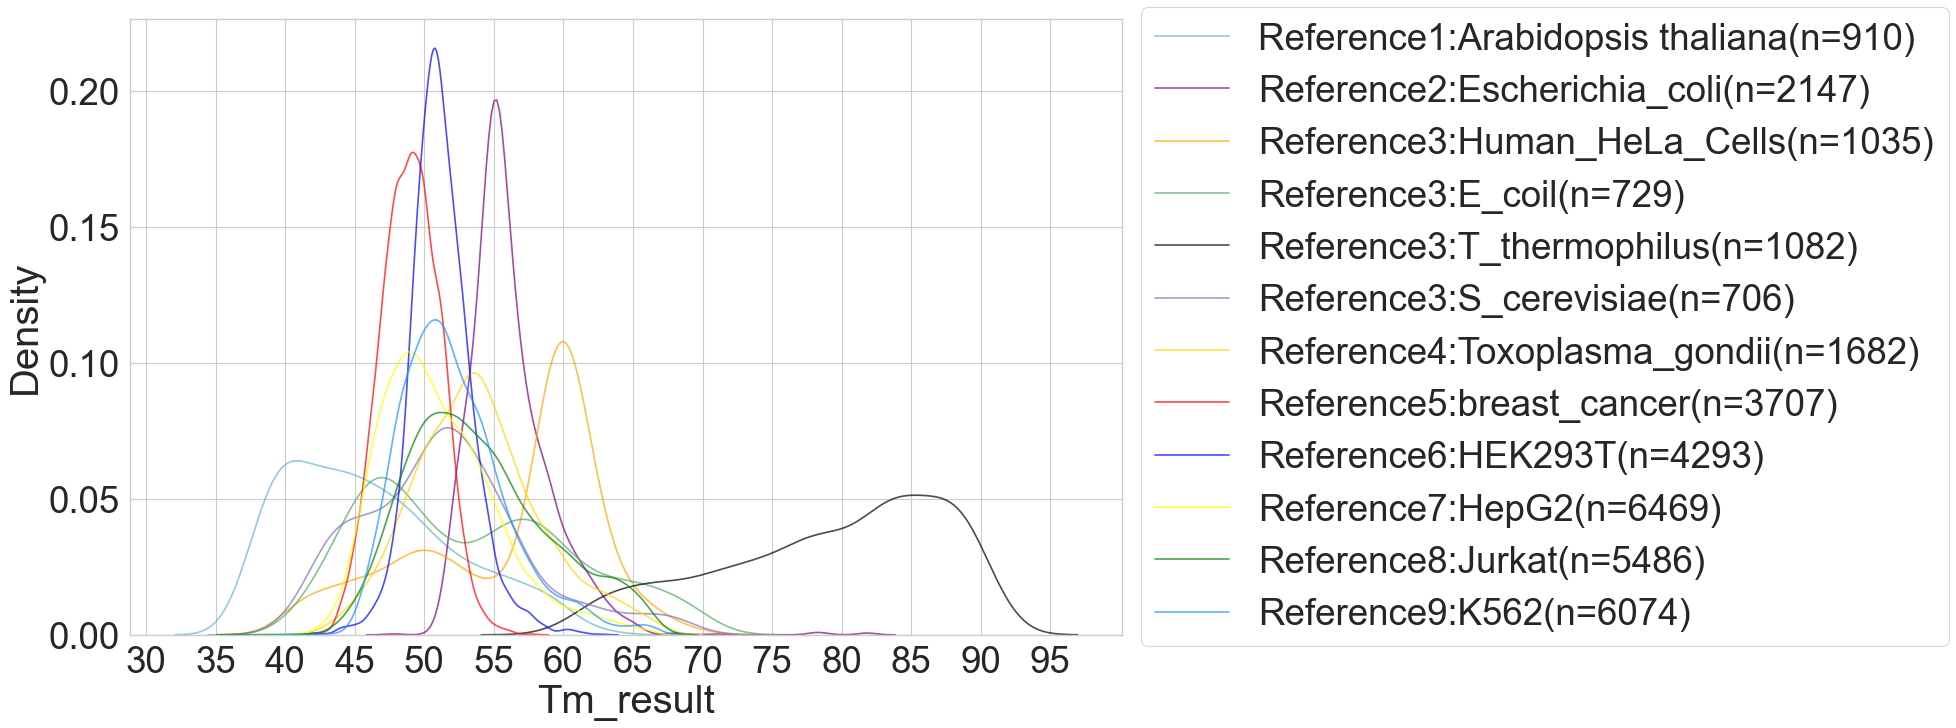

In [7]:
plt.figure(figsize=(16,10), dpi= 80)
sns.kdeplot(data_Arabidopsis_thaliana['Tm_result'], shade=False, color="c", label="Reference1:Arabidopsis thaliana(n=910)", alpha=.7)
sns.kdeplot(data1_Escherichia_coli_1['Tm_result'], shade=False, color="purple", label="Reference2:Escherichia_coli(n=2147)", alpha=.7)
sns.kdeplot(data_Human_HeLa_Cells['Tm_result'], shade=False, color="orange", label="Reference3:Human_HeLa_Cells(n=1035)", alpha=.7)
sns.kdeplot(data_E_coil['Tm_result'], shade=False, color="g", label="Reference3:E_coil(n=729)", alpha=.7)
sns.kdeplot(data_T_thermophilus['Tm_result'], shade=False, color="black", label="Reference3:T_thermophilus(n=1082)", alpha=.7)
sns.kdeplot(data_S_cerevisiae['Tm_result'], shade=False, color="m", label="Reference3:S_cerevisiae(n=706)", alpha=.7)
sns.kdeplot(data_Toxoplasma_gondii['Tm_result'], shade=False, color="gold", label="Reference4:Toxoplasma_gondii(n=1682)", alpha=.7)
sns.kdeplot(data_breast['Tm_(C)'], shade=False, color="red", label="Reference5:breast_cancer(n=3707)", alpha=.7)
sns.kdeplot(data1_HEK293T['Average Tm (°C)'], shade=False, color="blue", label="Reference6:HEK293T(n=4293)", alpha=.7)
sns.kdeplot(data_HepG2['Tm_(C)'], shade=False, color="yellow", label="Reference7:HepG2(n=6469)", alpha=.7)
sns.kdeplot(temp_Jurkat['Tm_result'], shade=False, color="green", label="Reference8:Jurkat(n=5486)", alpha=.7)
sns.kdeplot(data_K562['Tm_result'], shade=False, color="dodgerblue", label="Reference9:K562(n=6074)", alpha=.7)
sns.set(style="whitegrid", font_scale=3)
plt.xticks(range(30, 100, 5))  # 设置横坐标以5为间隔
#plt.axvline(x=45, color='blue', linestyle='--')  # 在X轴15处绘制虚线
#plt.axvline(x=32, color='blue', linestyle='--')  # 在X轴32处绘制虚线
#plt.axvline(x=60, color='blue', linestyle='--')  # 在X轴60处绘制虚线
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # 图注向右移动，不在图中
plt.show()

In [ ]:

plt.figure(figsize=(16,10), dpi= 80)
sns.kdeplot(data_Arabidopsis_thaliana['Tm_result'], shade=False, color="tab:blue", label="Reference1:Arabidopsis thaliana(n=752)", alpha=.7, linewidth=2.5)
sns.kdeplot(data1_Escherichia_coli_1['Tm_result'], shade=False, color="tab:orange", label="Reference2:Escherichia_coli(n=1870)", alpha=.7, linewidth=2.5)
sns.kdeplot(data_Human_HeLa_Cells['Tm_result'], shade=False, color="tab:green", label="Reference3:Human_HeLa_Cells(n=1035)", alpha=.7, linewidth=2.5)
sns.kdeplot(data_E_coil['Tm_result'], shade=False, color="tab:red", label="Reference4:E_coil(n=729)", alpha=.7, linewidth=2.5)
sns.kdeplot(data_T_thermophilus['Tm_result'], shade=False, color="tab:purple", label="Reference5:T_thermophilus(n=1082)", alpha=.7, linewidth=2.5)
sns.kdeplot(data_S_cerevisiae['Tm_result'], shade=False, color="tab:brown", label="Reference6:S_cerevisiae(n=706)", alpha=.7, linewidth=2.5)
sns.kdeplot(data_Toxoplasma_gondii['Tm_result'], shade=False, color="tab:pink", label="Reference7:Toxoplasma_gondii(n=1682)", alpha=.7, linewidth=2.5)
sns.kdeplot(data_breast['Tm_(C)'], shade=False, color="tab:olive", label="Reference8:breast_cancer(n=3707)", alpha=.7, linewidth=2.5)
sns.kdeplot(data1_HEK293T['Average Tm (°C)'], shade=False, color="tab:cyan", label="Reference9:HEK293T(n=4293)", alpha=.7, linewidth=2.5)
sns.kdeplot(data_HepG2['Tm_(C)'], shade=False, color="tab:gray", label="Reference10:HepG2(n=6469)", alpha=.7, linewidth=2.5)
sns.kdeplot(temp_Jurkat['Tm_result'], shade=False, color="tab:blue", label="Reference8:Jurkat(n=5486)", linestyle='--',alpha=.7)
sns.kdeplot(data_K562['Tm_result'], shade=False, color="tab:orange", label="Reference9:K562(n=6074)",linestyle='--', alpha=.7)
sns.set(style="whitegrid", font_scale=3)
plt.xticks(range(30, 100, 5))  # 设置横坐标以5为间隔
plt.axvline(x=45, color='blue', linestyle='--')  # 在X轴15处绘制虚线
#plt.axvline(x=32, color='blue', linestyle='--')  # 在X轴32处绘制虚线
plt.axvline(x=60, color='blue', linestyle='--')  # 在X轴60处绘制虚线
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # 图注向右移动，不在图中
plt.show()

